In [1]:
import numpy as np
import pandas as pd
import panel as pn
import hvplot.pandas

PRIMARY_COLOR = "#0072B5"
SECONDARY_COLOR = "#B54300"
CSV_FILE = (
    "https://raw.githubusercontent.com/holoviz/panel/main/examples/assets/occupancy.csv"
)

In [3]:
import xarray as xr
import xradar as xd
import cmweather
import matplotlib.pyplot as plt
import pyproj
#import cartopy
import hvplot.xarray

In [6]:
# dirname = "/Users/brenda/data/from_Alex/for_hawkeye_demo/Goshen_tornado_2009/DOW6/20090605";
dirname = "/Users/brenda/data/APAR"   # MICA_testing"
# need to send the earth radius because the latitudes don't vary
# enough for the default calculation
#
#filename = "cfrad.20090605_223048.231_to_20090605_223055.341_DOW6_PPI.nc"

#dirname = "/Users/brenda/data"
#filename = "cfrad.20161006_190650.891_to_20161006_191339.679_KAMX_SUR.nc"
# need to untar and gunzip .Z files
# filename = "cfrad.20010101_010000.006_to_20010101_010000.744_APAR_sim_AIR.nc" # "KTLX19910606_075656"
filename = "ncf_20010101_010000.nc"
localfilename = dirname + "/from_brad/cart/20010101" + "/" + filename
#radar = xd.io.open_cfradial1_datatree(localfilename) # , engine="netcdf4" ) #first_dim="auto")
#radar = xd.io.open(localfilename)
ds = xr.open_dataset(localfilename) # , group="sweep_0") # , engine="nexradlevel2")
display(ds)

<xarray.Dataset> Size: 65MB
Dimensions:         (time: 1, x0: 400, y0: 400, z0: 20)
Coordinates:
  * time            (time) datetime64[ns] 8B 2001-01-01T01:00:00
  * x0              (x0) float32 2kB -199.5 -198.5 -197.5 ... 197.5 198.5 199.5
  * y0              (y0) float32 2kB -199.5 -198.5 -197.5 ... 197.5 198.5 199.5
    lat0            (y0, x0) float32 640kB ...
    lon0            (y0, x0) float32 640kB ...
  * z0              (z0) float32 80B 0.5 1.5 2.5 3.5 4.5 ... 16.5 17.5 18.5 19.5
Data variables:
    start_time      (time) datetime64[ns] 8B ...
    stop_time       (time) datetime64[ns] 8B ...
    grid_mapping_0  int32 4B ...
    VEL             (time, z0, y0, x0) float32 13MB ...
    Zhh             (time, z0, y0, x0) float32 13MB ...
    WRF_U           (time, z0, y0, x0) float32 13MB ...
    WRF_V           (time, z0, y0, x0) float32 13MB ...
    WRF_W           (time, z0, y0, x0) float32 13MB ...
Attributes:
    Conventions:  CF-1.6
    history:      Created 2018-09-11T20:03:45ZApplying azimuth offset: 0, mod...
    institution:  EOL/NCAR
    source:       WRF_as_A
    title:        APAR_sim
    comment:

In [8]:
field = ds.data_vars.get("VEL")
display(field.long_name)
display(type(field))

'radial_velocity'

xarray.core.dataarray.DataArray

In [14]:
field.sizes
t = 0
z = 10
mydata = field[t,z,:,:]
mydatana = mydata.fillna(0)
display(mydatana.data)
#field_nonan = field.fillna(-99999.99)
#field_nonan[:,300].data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [15]:
list(ds.data_vars)

['start_time',
 'stop_time',
 'grid_mapping_0',
 'VEL',
 'Zhh',
 'WRF_U',
 'WRF_V',
 'WRF_W']

In [16]:
pn.extension(design="material", sizing_mode="stretch_width")

In [7]:
@pn.cache
def get_data():
  return pd.read_csv(CSV_FILE, parse_dates=["date"], index_col="date")

data = get_data()

data.tail()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
date,,,,,,
2015-02-10 09:29:00,21.05,36.0975,433.0,787.250000,0.005579,1
2015-02-10 09:29:59,21.05,35.9950,433.0,789.500000,0.005563,1
2015-02-10 09:30:59,21.10,36.0950,433.0,798.500000,0.005596,1
2015-02-10 09:32:00,21.10,36.2600,433.0,820.333333,0.005621,1
2015-02-10 09:33:00,21.10,36.2000,447.0,821.000000,0.005612,1


In [47]:
def transform_data(variable, window, sigma):
    """Retrieve data for the variable at the window=z; sigma selects the time"""
    #avg = data[variable].rolling(window=window).mean()
    #residual = data[variable] - avg
    #std = residual.rolling(window=window).std()
    #outliers = np.abs(residual) > std * sigma
    field = ds.data_vars.get(variable)
    #display(field.long_name)
    #display(type(field))
    #display(field[:,window].data)
    # TODO: make these parameters
    t = sigma
    z = window
    #t = 0
    #z = 10
    mydata = field[t,z,:,:]
    # t, x, y, z
    # mydata = field[t,200,:,z]
    field2 = mydata.fillna(-99999.99)
    #field2[sigma,:].data    
    #return field2[sigma,:], field2[sigma+1,:]
    return field2

#def transform_data(variable, window, sigma):
#    """Calculates the rolling average and identifies outliers"""
#    avg = data[variable].rolling(window=window).mean()
#    residual = data[variable] - avg
#    std = residual.rolling(window=window).std()
#    outliers = np.abs(residual) > std * sigma
#    return avg, avg[outliers]


def get_plot(variable="VEL", window=10, sigma=0):
    """Plots the rolling average and the outliers"""
    avg = transform_data(variable, window, sigma)
    #avg, highlight = transform_data(variable, window, sigma)
    return avg.hvplot(
        height=300, legend=False, color=PRIMARY_COLOR
    ) #  * highlight.hvplot.scatter(color=SECONDARY_COLOR, padding=0.1, legend=False)



In [48]:
#avg  = transform_data("VEL", 10, 0)
display(' - - - - - ')
# display(highlight.data)
#get_plot(variable='VEL', window=300, sigma=10)

#avg.hvplot(
#        height=300, legend=False, color=PRIMARY_COLOR
#    )

' - - - - - '

In [49]:
variable_widget = pn.widgets.Select(name="variable", value="VEL", options=list(ds.data_vars))
window_widget = pn.widgets.IntSlider(name="z", value=10, start=0, end=20)
sigma_widget = pn.widgets.IntSlider(name="time", value=0, start=0, end=1)

In [50]:
#variable_widget = pn.widgets.Select(name="variable", value="Temperature", options=list(data.columns))
#window_widget = pn.widgets.IntSlider(name="window", value=30, start=1, end=60)
#sigma_widget = pn.widgets.IntSlider(name="sigma", value=0, start=0, end=1)

In [51]:
get_plot(variable='VEL', window=10, sigma=0)

:Image   [x0,y0]   (radial_velocity)

In [52]:
bound_plot = pn.bind(
    get_plot, variable=variable_widget, window=window_widget, sigma=sigma_widget
)

In [53]:
widgets = pn.Column(variable_widget, window_widget, sigma_widget, sizing_mode="fixed", width=300)
pn.Column(widgets, bound_plot)

Traceback (most recent call last):
 File "/Users/brenda/miniforge3/envs/bokeh_heatmap_env/lib/python3.12/site-packages/pyviz_comms/__init__.py", line 340, in _handle_msg
 self._on_msg(msg)
 File "/Users/brenda/miniforge3/envs/bokeh_heatmap_env/lib/python3.12/site-packages/panel/viewable.py", line 478, in _on_msg
 doc.unhold()
 File "/Users/brenda/miniforge3/envs/bokeh_heatmap_env/lib/python3.12/site-packages/bokeh/document/document.py", line 776, in unhold
 self.callbacks.unhold()
 File "/Users/brenda/miniforge3/envs/bokeh_heatmap_env/lib/python3.12/site-packages/bokeh/document/callbacks.py", line 431, in unhold
 self.trigger_on_change(event)
 File "/Users/brenda/miniforge3/envs/bokeh_heatmap_env/lib/python3.12/site-packages/bokeh/document/callbacks.py", line 408, in trigger_on_change
 invoke_with_curdoc(doc, event.callback_invoker)
 File "/Users/brenda/miniforge3/envs/bokeh_heatmap_env/lib/python3.12/site-packages/bokeh/document/callbacks.py", line 443, in invoke_with_curdoc
 return f()
 ^^^
 File "/Users/brenda/miniforge3/envs/bokeh_heatmap_env/lib/python3.12/site-packages/bokeh/util/callback_manager.py", line 185, in invoke
 callback(attr, old, new)
 File "/Users/brenda/miniforge3/envs/bokeh_heatmap_env/lib/python3.12/site-packages/panel/reactive.py", line 474, in _comm_change
 state._handle_exception(e)
 File "/Users/brenda/miniforge3/envs/bokeh_heatmap_env/lib/python3.12/site-packages/panel/io/state.py", line 458, in _handle_exception
 raise exception
 File "/Users/brenda/miniforge3/envs/bokeh_heatmap_env/lib/python3.12/site-packages/panel/reactive.py", line 472, in _comm_change
 self._schedule_change(doc, comm)
 File "/Users/brenda/miniforge3/envs/bokeh_heatmap_env/lib/python3.12/site-packages/panel/reactive.py", line 454, in _schedule_change
 self._change_event(doc)
 File "/Users/brenda/miniforge3/envs/bokeh_heatmap_env/lib/python3.12/site-packages/panel/reactive.py", line 450, in _change_event
 self._process_events(events)
 File "/Users/brenda/miniforge3/envs/bokeh_heatmap_env/lib/python3.12/site-packages/panel/reactive.py", line 387, in _process_events
 self.param.update(**self_params)
 File "/Users/brenda/miniforge3/envs/bokeh_heatmap_env/lib/python3.12/site-packages/param/parameterized.py", line 2318, in update
 restore = dict(self_._update(arg, **kwargs))
 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
 File "/Users/brenda/miniforge3/envs/bokeh_heatmap_env/lib/python3.12/site-packages/param/parameterized.py", line 2351, in _update
 self_._batch_call_watchers()
 File "/Users/brenda/miniforge3/envs/bokeh_heatmap_env/lib/python3.12/site-packages/param/parameterized.py", line 2545, in _batch_call_watchers
 self_._execute_watcher(watcher, events)
 File "/Users/brenda/miniforge3/envs/bokeh_heatmap_env/lib/python3.12/site-packages/param/parameterized.py", line 2505, in _execute_watcher
 watcher.fn(*args, **kwargs)
 File "/Users/brenda/miniforge3/envs/bokeh_heatmap_env/lib/python3.12/site-packages/panel/param.py", line 882, in _replace_pane
 new_object = self.eval(self.object)
 ^^^^^^^^^^^^^^^^^^^^^^
 File "/Users/brenda/miniforge3/envs/bokeh_heatmap_env/lib/python3.12/site-packages/panel/param.py", line 1097, in eval
 return eval_function_with_deps(ref)
 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
 File "/Users/brenda/miniforge3/envs/bokeh_heatmap_env/lib/python3.12/site-packages/param/parameterized.py", line 165, in eval_function_with_deps
 return function(*args, **kwargs)
 ^^^^^^^^^^^^^^^^^^^^^^^^^
 File "/Users/brenda/miniforge3/envs/bokeh_heatmap_env/lib/python3.12/site-packages/param/depends.py", line 53, in _depends
 return func(*args, **kw)
 ^^^^^^^^^^^^^^^^^
 File "/Users/brenda/miniforge3/envs/bokeh_heatmap_env/lib/python3.12/site-packages/param/reactive.py", line 594, in wrapped
 return eval_fn()(*combined_args, **combined_kwargs)
 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
 File "/var/folders/qq/x4xqb32n60j3g7jdnvz3hkvr000x3n/T/ipykernel_39963/2160231730.py", line 35, in get_plot
 avg = transform_data(variable, window, sigma)
 ^^^^^^^^^^^^^^

Column(design=<class 'panel.theme.materi..., sizing_mode='stretch_width')
    [0] Column(design=<class 'panel.theme.materi..., sizing_mode='fixed', width=300)
        [0] Select(design=<class 'panel.theme.materi..., name='variable', options=['start_time', ...], sizing_mode='stretch_width', value='VEL')
        [1] IntSlider(design=<class 'panel.theme.materi..., end=20, name='z', sizing_mode='stretch_width', value=10)
        [2] IntSlider(design=<class 'panel.theme.materi..., name='time', sizing_mode='stretch_width')
    [1] ParamFunction(function, _pane=HoloViews, defer_load=False, design=<class 'panel.theme.materi..., sizing_mode='stretch_width')

In [74]:
#pn.template.MaterialTemplate(
#    site="Panel",
#    title="Getting Started App",
#    sidebar=[variable_widget, window_widget, sigma_widget],
#    main=[bound_plot],
#).servable(); # The ; is needed in the notebook to not display the template. Its not needed in a script

In [4]:
#@pn.cache
#def get_data():
#  return pd.read_csv(CSV_FILE, parse_dates=["date"], index_col="date")

#data = get_data()

#data.tail()
import requests
import json

#wdata = pd.read_json("https://api.weather.gov/radar/stations")

In [6]:
#df = pd.DataFrame({ 'radar_name': radar_name, 'Latitude' : lats, 'Longitude' : lons, 'coords':coords } )
#df.head(3)

,radar_name,Latitude,Longitude,coords
0,KBGM,-75.98472,42.19969,"[-75.98472, 42.1996899]"
1,KMVX,-97.32499,47.52805,"[-97.32499, 47.52805]"
2,KHPX,-87.28499,36.73666,"[-87.2849899, 36.73666]"


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
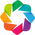

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]

In [13]:
# here ... 
#import geoviews as gv
#import geoviews.feature as gf

#from geoviews import opts
#from cartopy import crs

#gv.extension('bokeh', 'matplotlib')
#df2 = pd.DataFrame({ 'radar_name': ["boulder"], 'Latitude' : [40.014984], 'Longitude' : [-105.270546] } )
#df2.hvplot.points('Longitude', 'Latitude', geo=True, 
#                 tiles=True, color='red', alpha=0.2,
#                 )

In [42]:
#import xarray as xr
#import holoviews as hv
#import hvplot.xarray
#locs = ["KTYX", "KLGX"]
#data = [[-75.68, 43.75582], [-124.10663, 47.11689]]
#times = [1,2]
#foo = xr.DataArray(data, coords=[times, locs], dims=["lat", "lon"])
#foo



<xarray.DataArray (lat: 2, lon: 2)>
array([[ -75.68   ,   43.75582],
       [-124.10663,   47.11689]])
Coordinates:
  * lat      (lat) int64 1 2
  * lon      (lon) <U4 'KTYX' 'KLGX'

In [41]:
#foo.hvplot.points(x=loc[)

:Points   [location,rname]   (value)